# Toxic research
### This dataset was published on Kaggle by <a href="https://www.kaggle.com/blackmoon">АнатолийБельчиков</a>  and second part of dataset was scraped  from website <a href="https://otzovik.com/technology/communication/cellular_phones/">Otzovik</a>

In [40]:
import pandas as pd
import numpy as np
import pymysql

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

import nltk
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /home/akalend/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!


True

In [71]:
import pymysql


loc_conf = {
        'mysql_user': 'client',
        'mysql_db': 'nlp',
        'mysql_host': '127.0.0.1',
        'mysql_password': 'client',
    }
    


try:
    cnn = pymysql.connect(host=loc_conf['mysql_host'],
                         user=loc_conf['mysql_user'],
                         password=loc_conf['mysql_password'],
                         db=loc_conf['mysql_db'],
                         charset='utf8mb4',
                         cursorclass=pymysql.cursors.DictCursor,     # SSCursor DictCursor,
                         autocommit=True)
except:
    print ( '{"result" : "connection error"}')


In [72]:
sql = "select negative as comment, 1 as toxic from review"

with cnn.cursor() as cursor:
    cursor.execute(sql)
    rows =cursor.fetchall()

nagative = pd.DataFrame(rows)
nagative

,comment,toxic
0,"Слабая батарея, медленная зарядка.",1
1,Пока не нашла,1
2,отсутствуют,1
3,Нет,1
4,"Тормозит, камера не соответствет",1
...,...,...
2584,"камера, звук камеры не выкл",1
2585,для меня их нет.,1
2586,"Видео снимает без подсветки вспышки,тихий дина...",1
2587,много очень,1


In [63]:
dfComments = pd.read_csv('/home/akalend/projects/nlp/labeled.csv')
dfComments.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [73]:
df = dfComments
dfPositiv = df.loc[df['toxic'] == 0.0]
# dfPositiv
df = dfPositiv.append(nagative)
df

,comment,toxic
6,В шапке были ссылки на инфу по текущему фильму...,0.0
12,"Почитайте посты у этого автора,может найдете ч...",0.0
17,Про графику было обидно) я так то проходил все...,0.0
28,https: pp.userapi.com c848520 v848520411 11627...,0.0
35,"Возьмём как пример Россию, западноевропейские ...",0.0
...,...,...
2584,"камера, звук камеры не выкл",1.0
2585,для меня их нет.,1.0
2586,"Видео снимает без подсветки вспышки,тихий дина...",1.0
2587,много очень,1.0


In [126]:
df.to_csv('/home/akalend/projects/nlp/data.csv')

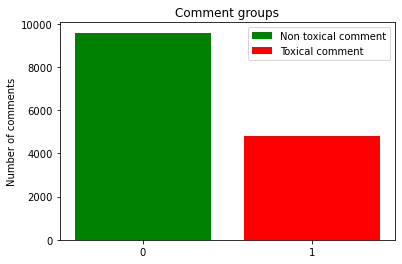

Comment description

      comment                                                               
        count unique                                                top freq
toxic                                                                       
0.0      9586   9586  Я чуть выше писал, что судебная практика расце...    1
1.0      4826   4826  Ну какой бред вы пишете. Породистое животное д...    1

              toxic
count  14412.000000
mean       0.334860
std        0.471958
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [75]:
desc = dfComments.groupby('toxic').describe()

plt.bar('0', desc['comment']['count'][0], label="Non toxical comment", color='green')
plt.bar('1', desc['comment']['count'][1], label="Toxical comment", color='red')
plt.legend()
plt.ylabel('Number of comments')
plt.title('Comment groups')
plt.show()

print('Comment description\n')
print(desc)
print()
print(dfComments.describe())

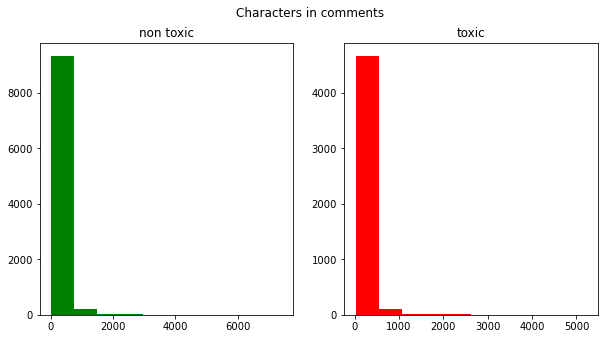

In [102]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.hist(dfComments[dfComments['toxic']==0]['comment'].str.len() ,color='green')
ax1.set_title('non toxic')

ax2.hist(dfComments[dfComments['toxic']==1]['comment'].str.len() ,color='red')
ax2.set_title('toxic')

fig.suptitle('Characters in comments')
plt.show()

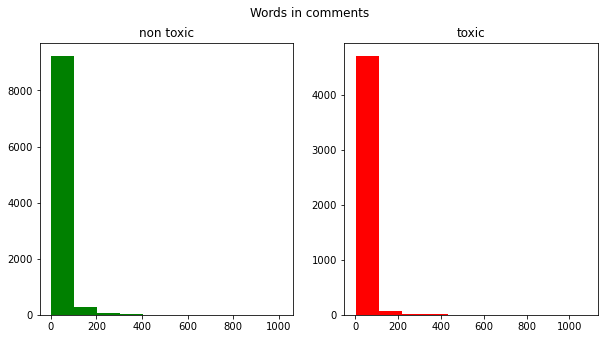

In [103]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.hist(dfComments[dfComments['toxic']==0]['comment'].str.split().map(lambda x: len(x)) ,color='green')
ax1.set_title('non toxic')

ax2.hist(dfComments[dfComments['toxic']==1]['comment'].str.split().map(lambda x: len(x)) ,color='red')
ax2.set_title('toxic')

fig.suptitle('Words in comments')
plt.show()

### Preporation

In [104]:
text = np.array(dfComments.comment.values)
target = dfComments.toxic.astype(int).values

In [105]:
def upperCaseRate(string):
    "Returns percentage of uppercase letters in the string"
    return np.array(list(map(str.isupper, string))).mean()

In [106]:
upcaseRate = list(map(upperCaseRate, dfComments.comment.values))

In [107]:
def cleanText(string):
    """This function deletes all symbols except Cyrilic and Base Latin alphabet,
    stopwords, functional parts of speech. Returns string of words stem."""
    # Common cleaning
    string = string.lower()
    string = re.sub(r"http\S+", "", string)
    string = str.replace(string,'Ё','е')
    string = str.replace(string,'ё','е')
    prog = re.compile('[А-Яа-яA-Za-z]+')
    words = prog.findall(string.lower())
    
    # Word Cleaning
    ## Stop Words
    stopwords = nltk.corpus.stopwords.words('russian')
    words = [w for w in words if w not in stopwords]
    ## Cleaning functional POS (Parts of Speech)
    functionalPos = {'CONJ', 'PRCL'}
    words = [w for w, pos in nltk.pos_tag(words, lang='rus') if pos not in functionalPos]
    ## Stemming
    stemmer = SnowballStemmer('russian')
    return ' '.join(list(map(stemmer.stem, words)))

In [108]:
%%time
text = list(map(cleanText, text))

CPU times: user 31.4 s, sys: 231 ms, total: 31.6 s
Wall time: 31.6 s


## Proccessing

In [109]:
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=.3, stratify=target, shuffle = True, random_state=0)
print('Dim of train:', len(X_train), '\tTarget rate: {:.2f}%'.format(y_train.mean()))
print("Dim of test:", len(X_test), '\tTarget rate: {:.2f}%'.format(y_test.mean()))

Dim of train: 10088 	Target rate: 0.33%
Dim of test: 4324 	Target rate: 0.33%


## Baseline

In [110]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()), # Prod feature: tokenizer=cleanText
            ("classifier", LinearSVC())]
        )

clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', LinearSVC())])

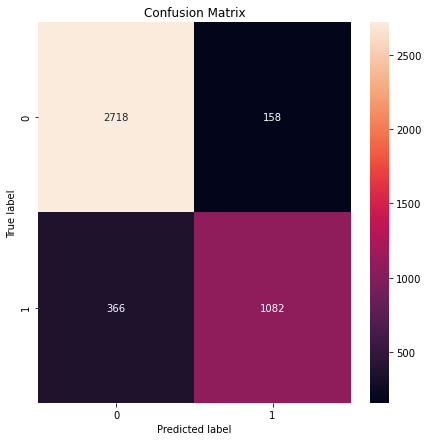

In [111]:
cm = metrics.confusion_matrix(y_test, clf_pipeline.predict(X_test))

def plotConfusionMatrix(cm):
    fig = plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

plotConfusionMatrix(cm)

In [112]:
print(metrics.classification_report(y_test, clf_pipeline.predict(X_test)))
f1_base = metrics.f1_score(y_test, clf_pipeline.predict(X_test))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2876
           1       0.87      0.75      0.81      1448

    accuracy                           0.88      4324
   macro avg       0.88      0.85      0.86      4324
weighted avg       0.88      0.88      0.88      4324



## Adjusts

In [113]:
print('\n'.join(clf_pipeline.get_params().keys()))

memory
steps
verbose
vectorizer
classifier
vectorizer__analyzer
vectorizer__binary
vectorizer__decode_error
vectorizer__dtype
vectorizer__encoding
vectorizer__input
vectorizer__lowercase
vectorizer__max_df
vectorizer__max_features
vectorizer__min_df
vectorizer__ngram_range
vectorizer__norm
vectorizer__preprocessor
vectorizer__smooth_idf
vectorizer__stop_words
vectorizer__strip_accents
vectorizer__sublinear_tf
vectorizer__token_pattern
vectorizer__tokenizer
vectorizer__use_idf
vectorizer__vocabulary
classifier__C
classifier__class_weight
classifier__dual
classifier__fit_intercept
classifier__intercept_scaling
classifier__loss
classifier__max_iter
classifier__multi_class
classifier__penalty
classifier__random_state
classifier__tol
classifier__verbose


In [114]:
parameters = {'vectorizer__max_features': (10**3, 10**4),
              'vectorizer__ngram_range': ((1, 2),(2, 3)),
              'classifier__penalty': ('l1','l2'),
              'classifier__C': (range(1,10,2))
             }

In [115]:
%%time
gs_clf = GridSearchCV(clf_pipeline, parameters, scoring='f1', cv = 4, n_jobs=-1)
gs_clf.fit(X_train, y_train)

CPU times: user 1.48 s, sys: 222 ms, total: 1.7 s
Wall time: 20.9 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', LinearSVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': range(1, 10, 2),
                         'classifier__penalty': ('l1', 'l2'),
                         'vectorizer__max_features': (1000, 10000),
                         'vectorizer__ngram_range': ((1, 2), (2, 3))},
             scoring='f1')

In [116]:
print(metrics.classification_report(y_test, gs_clf.predict(X_test)))
f1_gsLSVC = metrics.f1_score(y_test, gs_clf.predict(X_test))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2876
           1       0.85      0.74      0.79      1448

    accuracy                           0.87      4324
   macro avg       0.87      0.84      0.85      4324
weighted avg       0.87      0.87      0.87      4324



### Randomized Search CV on TfidfVectorizer and LogisticRegression

In [117]:
parameters = { #'vectorizer__max_features': (10**2, 10**3),
              'vectorizer__ngram_range': [(1, 2),(1, 3)],
              'vectorizer__min_df': [0.,.2,.4,.6,.8,1],
              'classifier__penalty': ('l1','l2'),
              'classifier__C': (range(1,10,2)),
             }

In [118]:
clf_pipeline_LogitReg = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LogisticRegression())]
        )

In [119]:
def plotROC(y_test, probs, titl=''):
    if titl!='':
        titl = ' ('+titl+')' 
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic'+titl)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return None

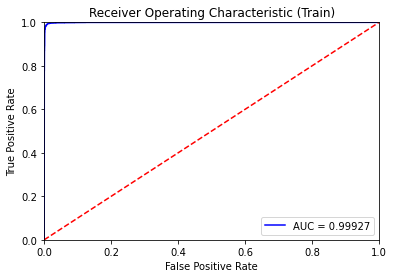

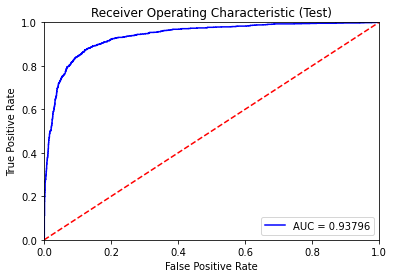

CPU times: user 5.79 s, sys: 120 ms, total: 5.91 s
Wall time: 14.9 s


In [120]:
%%time
rndgs_clf_LogitReg = RandomizedSearchCV(clf_pipeline_LogitReg, parameters, scoring='f1', cv = 4, n_jobs=-1)
rndgs_clf_LogitReg.fit(X_train, y_train)

probs = rndgs_clf_LogitReg.predict_proba(X_train)[:,1]
plotROC(y_train, probs, 'Train')

probs = rndgs_clf_LogitReg.predict_proba(X_test)[:,1]
plotROC(y_test, probs, 'Test')

Looks like overfited model. There's too high AUC on train.

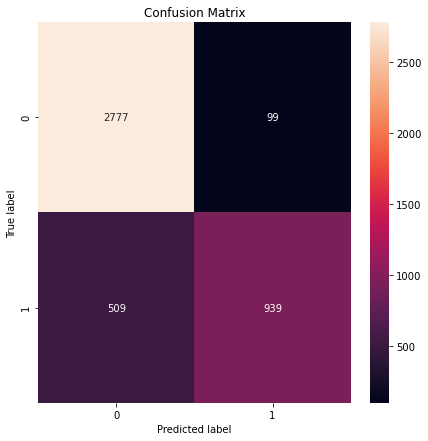

In [121]:
plotConfusionMatrix(metrics.confusion_matrix(y_test, rndgs_clf_LogitReg.predict(X_test)))

In [122]:
print(metrics.classification_report(y_test, rndgs_clf_LogitReg.predict(X_test)))
f1_rndLogR = metrics.f1_score(y_test, rndgs_clf_LogitReg.predict(X_test))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2876
           1       0.90      0.65      0.76      1448

    accuracy                           0.86      4324
   macro avg       0.87      0.81      0.83      4324
weighted avg       0.87      0.86      0.85      4324



### Add more parameters

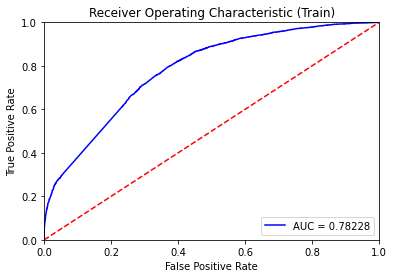

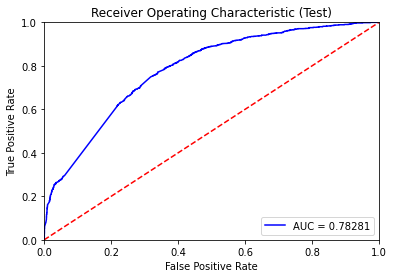

CPU times: user 1.37 s, sys: 40.2 ms, total: 1.41 s
Wall time: 5.89 s


In [123]:
%%time
parameters = {'vectorizer__max_features': (10**2, 10**3),
              'vectorizer__ngram_range': [(1, 2),(1, 3)],
              'vectorizer__min_df': [0.,.2,.4,.6,.8,1],
              'classifier__penalty': ('l1','l2'),
              'classifier__C': (range(1,10,2)),
             }

clf_pipeline_LogitReg = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LogisticRegression())]
        )

rndgs_clf_LogitReg = RandomizedSearchCV(clf_pipeline_LogitReg, parameters, scoring='f1', cv = 4, n_jobs=-1)
rndgs_clf_LogitReg.fit(X_train, y_train)

probs = rndgs_clf_LogitReg.predict_proba(X_train)[:,1]
plotROC(y_train, probs, 'Train')

probs = rndgs_clf_LogitReg.predict_proba(X_test)[:,1]
plotROC(y_test, probs, 'Test')

In [124]:
print(metrics.classification_report(y_test, rndgs_clf_LogitReg.predict(X_test)))
f1_rndLogR_2 = metrics.f1_score(y_test, rndgs_clf_LogitReg.predict(X_test))

              precision    recall  f1-score   support

           0       0.72      0.96      0.82      2876
           1       0.76      0.27      0.40      1448

    accuracy                           0.73      4324
   macro avg       0.74      0.61      0.61      4324
weighted avg       0.73      0.73      0.68      4324



In [39]:
pd.DataFrame([f1_base, f1_gsLSVC, f1_rndLogR, f1_rndLogR_2], index=['BaseLine', 'GS_LSVC', 'rndGS_LogR', 'rndGS_LogR_Adj'], columns=['f1 score'])

,f1 score
BaseLine,0.805060
GS_LSVC,0.793486
rndGS_LogR,0.782236
rndGS_LogR_Adj,0.706065


## Baseline algorithm looks simple and good enough. The Confusion Matrix isn't bad too. Howewer, the Logistic Regression forecasts probubilities of classification. Hence, we are able to plot Reciever Operator Curve (ROC) and get AUC (Area under Curve) value. It may be a useful for the next improvements of this notebook.